In [151]:
import numpy as np
from ipywidgets import *
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt 

In [152]:
# Forward FFT w.r.t. the second variable
def ffy(s):
    s[np.newaxis]
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(s.T))).T

In [153]:
# Inverse FFT w.r.t. the second variable
def iffy(fs):
    fs[np.newaxis]
    return np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(fs.T))).T

In [154]:
# orital parameters
h = 400e+03 # obital height (m)
G = 6.6743e-11 # Gravitational Constant (SI)
R = 6.3781e+06 # radius of earth (m)
Me = 5.97219e+24 # mass of the earth (kgs)

In [155]:
vs = np.sqrt(G*Me/(h+R)) # orbital speed of Satellite @ h
vs_in_km = vs/1000 # m/s to km/s
print("%.3f"% vs_in_km, "km/s")

7.669 km/s


In [156]:
look_angle = 4.033*np.pi/180 # look angle (rad)
target_range = h/np.cos(look_angle) # centre of the target range
print("%.3f"% (target_range/1000), "Kms")

400.993 Kms


In [157]:
# some constants and parameters
c = 3e+08 #speed of light (m/s)
Bo = 200e06 # Baseband bandwidth (hz)
wo = 2*np.pi*Bo # radian/s baseband
fc = 5.5e9 # Carrier frequency (hz)
wc = np.pi*2*fc # radian/s carrier 
Xc = 28.210e03 # centre of the range 
Xo = 20e03 # Range distance from center of target area
k = wo/c # wavenumber (for both path)
lamda = 2*np.pi/k # wavelength
Tp = 65e-6 # pulse Repetition Interval (s)

In [158]:
alpha = wo/Tp # chirp rate
beta = wc-alpha*Tp # modified chirp carrier
print(alpha, beta)

19332877868244.88 33300882128.051807


In [159]:
delta_x = c/(4*Bo) # range resolution
delta_t = np.pi/(2*alpha*Tp) # Time domain sampling sepration
print(delta_t, delta_x)

1.2500000000000004e-09 0.375


In [160]:
Ts = (2*(Xc-Xo))/c # start time of sampling 
Tf = Tp + (2*(Xc+Xo))/c # end time of sampling
Tx = 4*Xo/c # Range swath echo time period
print(Ts, Tf)

5.473333333333333e-05 0.0003864


In [161]:
delta_tc = np.pi/(2*alpha*Tx)
print(delta_tc)

3.0468750000000004e-10


In [162]:
# if Tp >Tx use compressed signal parameters 

In [163]:
flag = 0
print(Tx, Tp)

0.0002666666666666667 6.5e-05


In [164]:
if Tx < Tp: # aliasing condition
    flag = 1
    delta_temp = delta_t;
    delta_t = delta_tc
print(flag)

0


In [165]:
# measurnment paramters

In [166]:
n = 2*np.ceil((0.5*(Tf-Ts))/delta_t) # number of time samples
t = Ts+np.arange(n)*delta_t # Time array for data acquisition
delta_w = (np.pi*2)/(n*delta_t) # Frequency domain sampling
w = wc+delta_w*np.arange(-n/2, n/2, 1)# Frequency array (centered at carrier)
x = (Xc) + 0.5*c*delta_t*np.arange(-n/2, n/2, 1) # range bins (array); reference signal is
                          # for target at x=Xc.
kx=(2*w)/c # Spatial (range) frequency array
print(np.shape(w)); print(n)

(265334,)
265334.0


In [167]:
ntarget = 4 # number of target

In [168]:
# target parameter
# xn: range
xn = np.empty(ntarget)
xn[1] = 0; xn[2] = 0.2*Xo; xn[3] = 0.7*Xo; xn[0] = -0.5*Xo

# fn: reflectivity
fn = np.empty(ntarget)
fn[0] = 0.3; fn[1] = 0.7; fn[2] = 0.8; fn[3] = 1

In [169]:
# simulation

s = np.zeros(int(n)) # initialization of echo
na = 8 # number of harmonics in the random phase
ar = np.concatenate((np.random.rand(1,na), np.zeros([1, int(n-na)])), axis = 1) # amplitudes of the harmonics
ter = 2*np.pi*np.concatenate((np.random.rand(1,na), np.zeros([1, int(n-na)])), axis = 1) # phase of the harmonics
print(np.shape(ter), np.shape(w), np.shape(ar))
for i in range(ntarget):
    td = t - 2*(Xc + xn[i])/c;
    pha = beta*td + alpha*np.power(td, 2) # chirp phase
    for j in range(na): # Loop for CPM harmonics
        pha = pha + ar[0,j]*np.cos((w[int(n/2)+1+j] - wc)*td+ter[0,j])
    s = s + np.multiply(fn[i]*np.exp(1j*pha),((td >= 0) & (td <= Tp)))  
print(np.shape(s), np.shape(pha), np.shape(fn))                    

(1, 265334) (265334,) (1, 265334)
(265334,) (265334,) (4,)


In [170]:
# If flag=1, i.e., Tx < Tp, perform upsmapling
if flag == 1:
    tdo = t - 2*(Xc)/c 
    phao = beta*tdo + alpha*np.power(tdo, 2) # Reference chirp phase
    scb = np.multiply(np.conj(s), np.exp(1j*phao)) # Baseband compressed signal (This is done by hardware)
    print(np.shape(scb))
    scb = np.append(scb,scb[::-1]) # Append mirror image in time to reduce wrap, around errors in interpolation (upsampling)
    print(np.shape(scb))
    fscb = ffy(scb) # F.T. of compressed signal w.r.t. time
    delta_t = delta_temp # Time sampling for echoed signal
    n_up = 2*np.ceil((0.5*(Tf-Ts))/delta_t) # Number of time samples for upsampling
    nz = n_up - n # number of zeros for upsmapling is 2*nz
    fscb = (n_up/n)*np.concatenate((np.zeros([1,int(nz)]), fscb, np.zeros([1,int(nz)])), axis = None)
    scb = iffy(fscb)
    scb = scb[0:int(n_up)] # Remove mirror image in time
    print(np.shape(scb))
    n = n_up # Upsampled parameters
    t = Ts + np.arange(n)*delta_t # Time array for data acquisition
    delta_w = 2*np.pi/(n*delta_t) # Frequency domain sampling
    w = wc + delta_w*np.arange(-n/2, n/2,1) # Frequency array (centered at carrier)
    x = Xc + 0.5*c*delta_t*np.arange(-n/2,n/2,1) # range bins (array); reference signal is for target at x=Xc.
    kx = 2*w/c # Spatial (range) frequency array
    tdo = t - 2*(Xc)/c
    s = np.multiply(np.conjugate(scb), np.exp(1j*beta*tdo + 1j*alpha*(np.power(tdo,2)))) # Decompression
    print(n, n_up)

In [171]:
# Reference echoed signal
tdo = t - 2*(Xc)/c 
phao = beta*tdo + alpha*(np.power(tdo,2)) # Chirp (LFM) phase

In [172]:
# Loop for CPM harmonics
for i in range(na):
    phao = phao + ar[0,j]*np.cos((w[int(n/2)+1+j])-wc)*tdo + ter[0,j] 

In [173]:
so = np.exp(1j*phao)*((tdo>=0)&(tdo<=Tp))

In [174]:
# Baseband conversion
sb = np.multiply(s, np.exp(-1*1j*wc*t))
sbo = np.multiply(so, np.exp(-1*1j*wc*t))                 

<IPython.core.display.Javascript object>


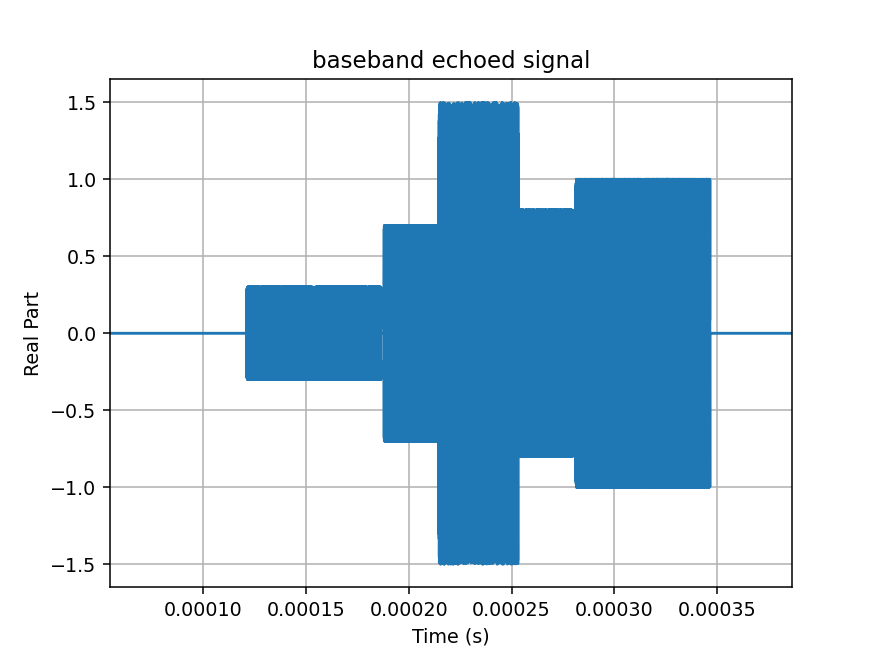

In [175]:
plt.figure(1, dpi=100)
plt.plot(t, np.real(sb))
plt.xlabel("Time (s)")
plt.ylabel("Real Part")
plt.title("baseband echoed signal")
plt.axis([Ts, Tf, 1.1*np.min(np.real(sb)), 1.1*np.max(np.real(sb))])
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


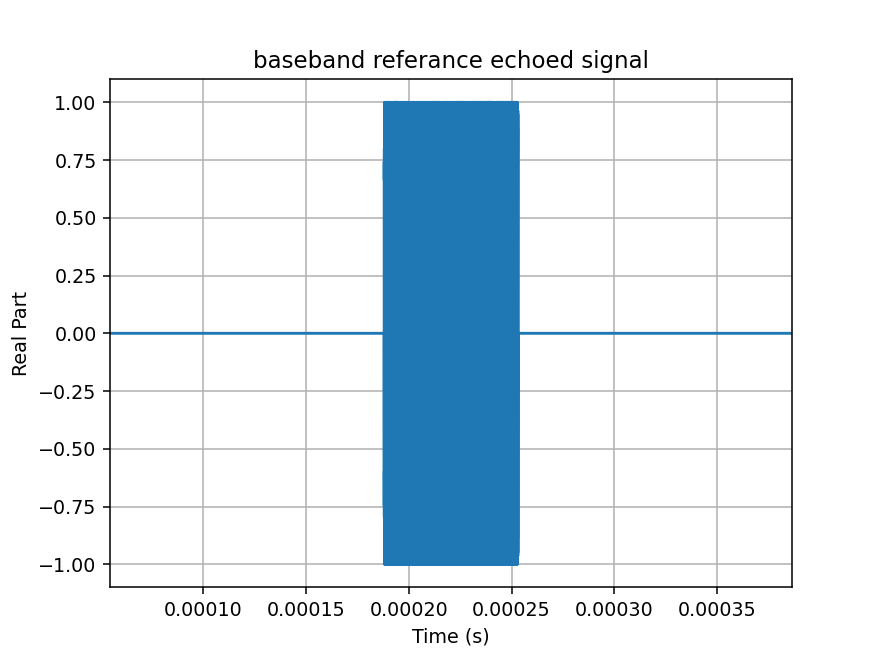

In [176]:
# Real part of the Baseband referance echoed signal

plt.figure(2, dpi=100)
plt.plot(t, np.real(sbo))
plt.xlabel("Time (s)")
plt.ylabel("Real Part")
plt.title("baseband referance echoed signal")
plt.axis([Ts, Tf, 1.1*np.min(np.real(sbo)), 1.1*np.max(np.real(sbo))])
plt.grid(True)
plt.show()

In [177]:
# Reconstruction

In [178]:
# Fourier Transform of baseband referance echo
fsb = np.array(ffy(sb)); fsbo = np.array(ffy(sbo)); print(np.shape(fsb), np.shape(fsbo))

(265334,) (265334,)


In [179]:
# power equalization
mag = np.abs(fsbo)
amp_max = 1/np.sqrt(2) # Maximum amplitude for equalization
afsbo = np.abs(fsbo)
p_max = np.max(afsbo)
I = np.where(afsbo>amp_max*p_max); I[0].tolist()
nI = len(I[0].tolist())
# print(I[0].tolist(), nI, np.shape(afsbo))

In [180]:
fsbo_1 = fsbo[I[0].tolist()]
afsbo_1 = afsbo[I[0].tolist()]
pow_1 = amp_max*(p_max**2)*np.ones(nI)
pow_phase_1 = np.exp(1j*np.angle(fsbo_1))
print(np.shape(np.array(fsbo_1)),np.shape(np.array(afsbo_1)), np.shape(np.array(pow_1)), np.shape(np.array(pow_phase_1)))

(132050,) (132050,) (132050,) (132050,)


In [181]:
fsbo[I[0].tolist()] = np.multiply(np.divide(pow_1, afsbo_1), pow_phase_1)

In [182]:
# Apply a window (e.g., power window) on fsb0 here
E = np.sum(np.multiply(mag, np.abs(fsbo)))

<IPython.core.display.Javascript object>


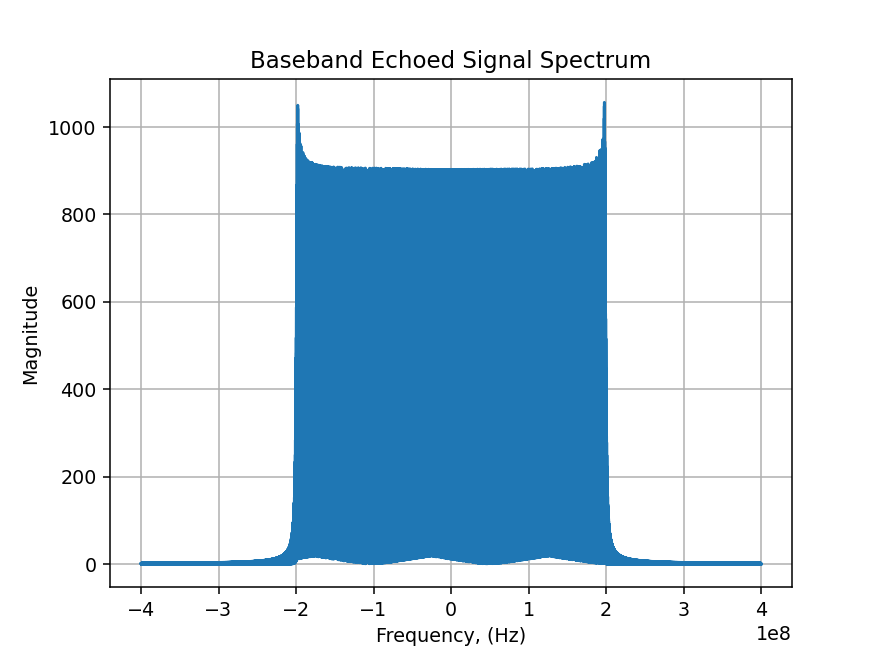

In [183]:
plt.figure(3, dpi=100)
plt.plot((w-wc)/(2*np.pi), np.abs(fsb))
plt.xlabel('Frequency, (Hz)')
plt.ylabel('Magnitude')
plt.title('Baseband Echoed Signal Spectrum')
# plt.axis([np.min((w-wc)/(2*np.pi)), np.max((w-wc)/(2*np.pi)), np.min(np.abs(fsb)), np.max(np.abs(fsb))])
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


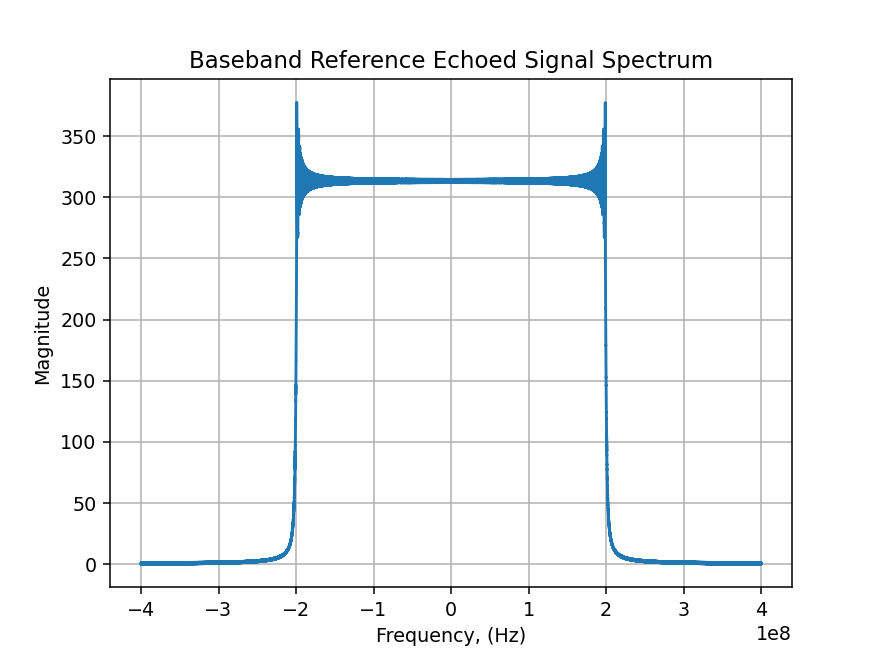

In [184]:
plt.figure(4, dpi=100)
plt.plot((w-wc)/(2*np.pi),np.abs(fsbo))
plt.xlabel('Frequency, (Hz)')
plt.ylabel('Magnitude')
plt.title('Baseband Reference Echoed Signal Spectrum')
# plt.axis([np.min((w-wc)/(2*np.pi)), np.max((w-wc)/(2*np.pi)), np.min(np.abs(fsbo)), np.max(np.abs(fsbo))])
plt.grid(True)
plt.show()

In [185]:
# Matched Filtering

In [186]:
fsmb = np.multiply(fsb,np.conjugate(fsbo))

<IPython.core.display.Javascript object>


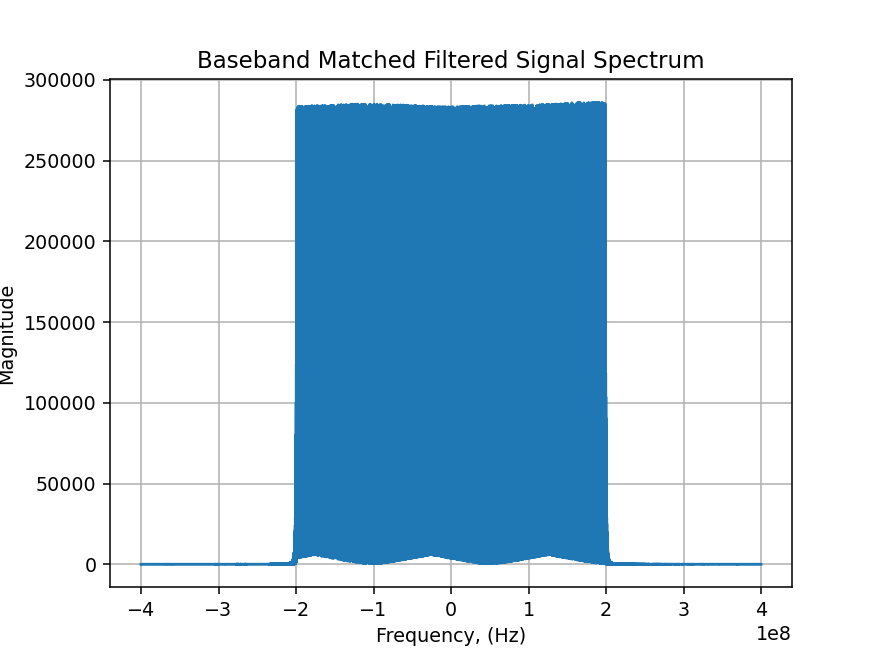

In [187]:
plt.figure(5, dpi=100)
plt.plot((w-wc)/(2*np.pi),np.abs(fsmb))
plt.xlabel('Frequency, (Hz)')
plt.ylabel('Magnitude')
plt.title('Baseband Matched Filtered Signal Spectrum')
plt.grid(True)
plt.show()

In [188]:
# Inverse Fourier Transform

In [189]:
smb = iffy(fsmb) # Matched filtered signal (range reconstruction)
print(np.shape(fsmb))

(265334,)


<IPython.core.display.Javascript object>


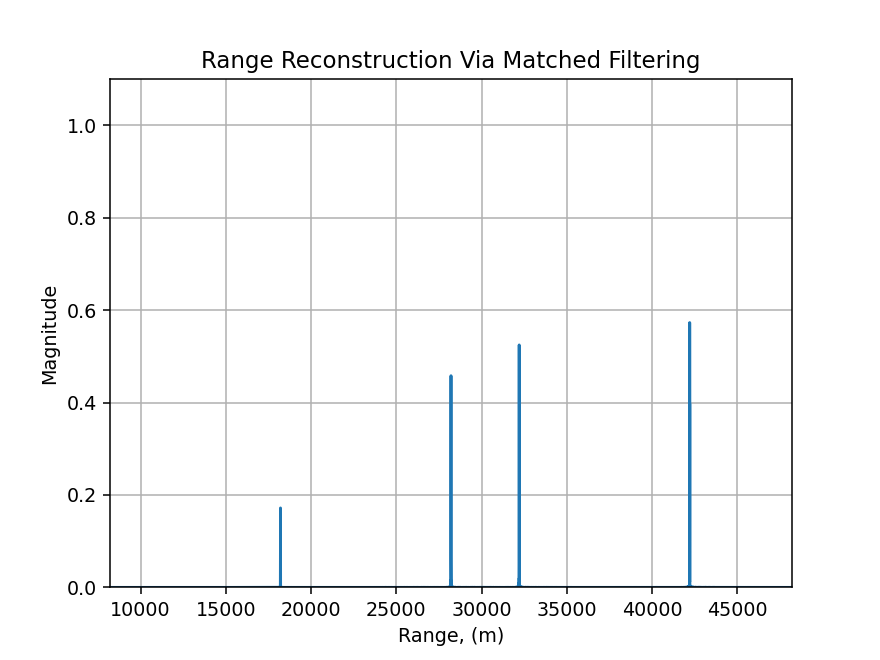

In [190]:
# Display
plt.figure(6, dpi=100)
plt.plot(x,(n/E)*np.abs(smb))
plt.xlabel('Range, (m)')
plt.ylabel('Magnitude')
plt.title('Range Reconstruction Via Matched Filtering')
plt.axis([Xc-Xo, Xc+Xo, 0, 1.1])
plt.grid(True)
plt.show()

In [191]:
print(Xc-Xo, Xc+Xo)

8210.0 48210.0


In [192]:
# Time domain Compression

In [193]:
tdo = t - 2*(Xc)/c 
scb = np.multiply(np.conjugate(s), np.exp(1j*beta*tdo + (1j*alpha*(np.power(tdo,2))))) # Baseband compressed signal

<IPython.core.display.Javascript object>


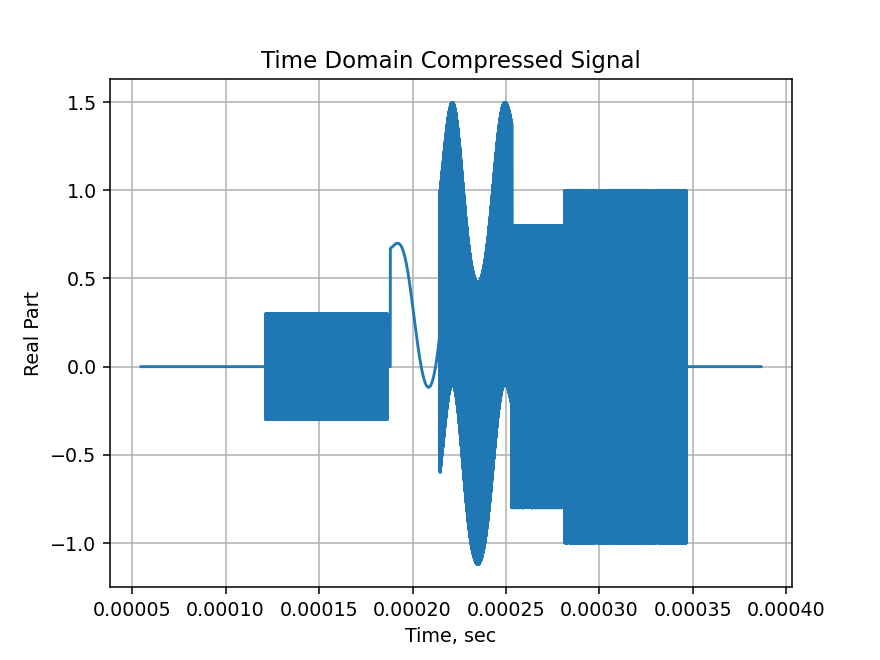

In [194]:
plt.figure(7, dpi=100)
plt.plot(t,np.real(scb))
plt.xlabel('Time, sec')
plt.ylabel('Real Part')
plt.title('Time Domain Compressed Signal')
plt.grid(True)
plt.show()

In [195]:
fscb = ffy(scb)
x = (c*(w-wc))/(4*alpha) # Range array for time domain compression

<IPython.core.display.Javascript object>


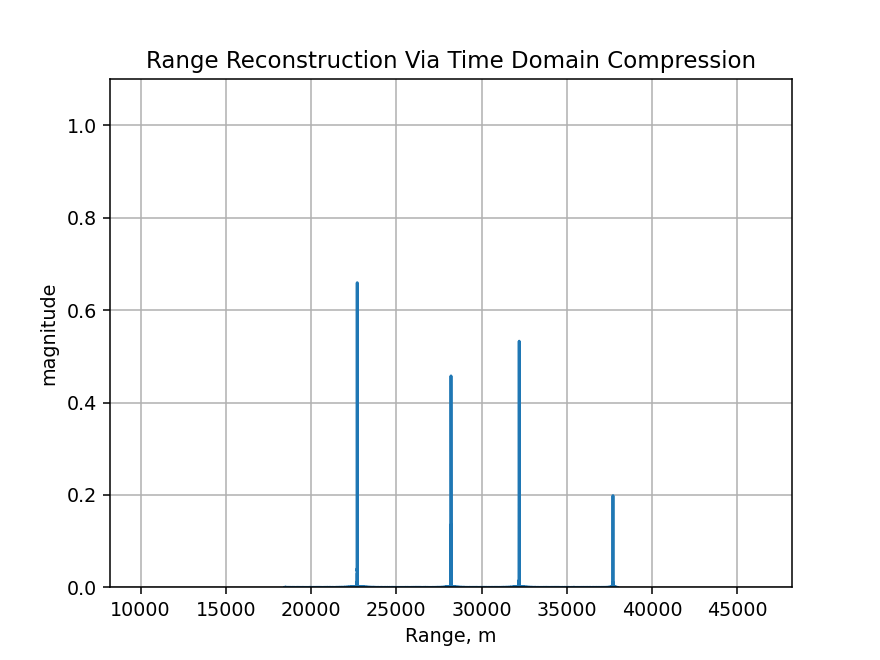

In [196]:
plt.figure(8, dpi=100)
plt.plot(x+Xc,(delta_t/Tp)*np.abs(fscb))
plt.xlabel('Range, m')
plt.ylabel('magnitude')
plt.title('Range Reconstruction Via Time Domain Compression')
plt.axis([Xc-Xo, Xc+Xo, 0, 1.1])
plt.grid(True)
plt.show()